In [1]:
import numpy as np
w = np.array([2, 1, 5, 3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [2]:
w_r = np.flip(w)
w_r

array([3, 5, 1, 2])

In [3]:
w_r = w[::-1]

In [6]:
for i in range(6):
    print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


In [7]:
from scipy.signal import convolve
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

In [8]:
from scipy.signal import correlate

In [9]:
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

In [10]:
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [11]:
correlate(x,w,mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [13]:
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
w = np.array([[2,0], [0, 0]])
from scipy.signal import correlate2d
correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [14]:
correlate2d(x, w , mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [16]:
import tensorflow as tf
x_4d = x.astype(np.float).reshape(1, 3, 3, 1)
w_4d = w.reshape(2, 2, 1, 1)

/Users/h/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/h/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/h/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [18]:
c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')

In [19]:
c_out.numpy().reshape(3,3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

In [20]:
c_out

<tf.Tensor: shape=(1, 3, 3, 1), dtype=float64, numpy=
array([[[[ 2.],
         [ 4.],
         [ 6.]],

        [[ 8.],
         [10.],
         [12.]],

        [[14.],
         [16.],
         [18.]]]])>

In [21]:
x_4d

array([[[[1.],
         [2.],
         [3.]],

        [[4.],
         [5.],
         [6.]],

        [[7.],
         [8.],
         [9.]]]])

In [22]:
x = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])

In [23]:
x = x.reshape(1, 4, 4, 1)

In [25]:
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')

In [27]:
p_out.numpy().reshape(2, 2)

array([[ 6,  8],
       [14, 16]])

In [28]:
def relu(x):
    return np.maximum(x, 0)

In [29]:
x = np.array([-1, 2, -3, 4, -5])

In [30]:
relu(x)

array([0, 2, 0, 4, 0])

In [31]:
r_out = tf.nn.relu(x)

In [32]:
r_out.numpy()

array([0, 2, 0, 4, 0])

In [77]:
class ConvolutionNeuralNetwork:
    def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=.1):
        self.n_kernels = n_kernels
        self.kernel_size = 3
        self.optimizer = None
        self.conv_w = None
        self.conv_b = None
        self.units = units
        self.batch_size = batch_size
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        
    def forpass(self, x):
        c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
        r_out = tf.nn.relu(c_out)
        p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
        f_out = tf.reshape(p_out, [x.shape[0], -1])
        z1 = tf.matmul(f_out, self.w1) + self.b1
        
        a1 = tf.nn.relu(z1)

        z2 = tf.matmul(a1, self.w2) + self.b2
        return z2
    
    def init_weights(self, input_shape, n_classes):
        g = tf.initializers.glorot_uniform()
        self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
        self.conv_b = tf.Variable(np.random.randn(self.n_kernels), dtype=float)
        n_features = 14*14*self.n_kernels
        self.w1 = tf.Variable(g((n_features, self.units)))
        self.b1 = tf.Variable(np.random.randn(self.units), dtype=float)
        self.w2 = tf.Variable(g((self.units, n_classes)))
        self.b2 = tf.Variable(np.random.randn(n_classes), dtype=float)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape, y.shape[1])
        self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
        
        for i in range(epochs):
            print(f'Epoch {i} >> ', end= ' ')
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch)
                batch_losses.append(self.get_loss(x_batch, y_batch))
            print()
            self.losses.append(np.mean(batch_losses))
            self.val_losses.append(self.get_loss(x_val, y_val))
            
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size
        indexes = np.random.permutation(np.arange(len(x)))
        x = x [indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i+1)
            yield x[start:end], y[start:end]
            
    def training(self, x, y):
        m = len(x)
        with tf.GradientTape() as tape:
            z = self.forpass(x)
            loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
            loss = tf.reduce_mean(loss)
            
        weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
        
        grads = tape.gradient(loss, weights_list)
        self.optimizer.apply_gradients(zip(grads, weights_list))
        
    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z.numpy(), axis=1)
    
    def score(self, x, y):
        return np.mean(self.predict(x) == np.argmax(y, axis=1))
    
    def get_loss(self,x, y):
        z = self.forpass(x)
        loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
        return loss.numpy()

In [45]:
x = tf.Variable(np.array([1., 2., 3.]))
with tf.GradientTape() as tape:
    y = x**3 + 2*x + 5

In [46]:
print(tape.gradient(y, x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


In [47]:
x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
    y = tf.nn.softmax(x)

In [48]:
print(tape.gradient(y, x))

tf.Tensor([1.99908031e-17 5.43406367e-17 1.47713165e-16], shape=(3,), dtype=float64)


In [49]:
tf.nn.softmax_cross_entropy_with_logits(y,x)

<tf.Tensor: shape=(), dtype=float64, numpy=0.8323955818399388>

In [50]:
y


<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0.09003057, 0.24472847, 0.66524096])>

In [66]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [67]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                 stratify=y_train_all, test_size=.2,
                                                 random_state=42)

In [68]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [69]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [70]:
x_train.shape

(48000, 28, 28, 1)

In [71]:
x_train = x_train / 255
x_val = x_val/255

In [78]:
cn = ConvolutionNeuralNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=.01)

In [79]:
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

Epoch 0 >>  .......................................................................................................................................................................................................................................................................................................................................................................................
Epoch 1 >>  .......................................................................................................................................................................................................................................................................................................................................................................................
Epoch 2 >>  ....................................................................................................................................................................................................................

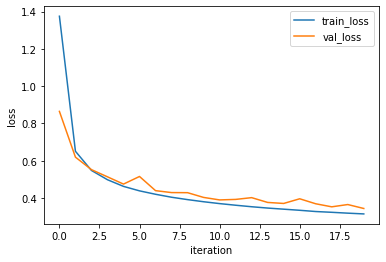

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [81]:
cn.score(x_val, y_val_encoded)

0.87875

In [82]:
# by keras

In [83]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [84]:
conv1 = tf.keras.Sequential()

In [85]:
conv1.add(Conv2D(10, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)))

In [86]:
conv1.add(MaxPooling2D((2,2)))

In [87]:
conv1.add(Flatten())

In [88]:
conv1.add(Dense(100, activation='relu'))

In [89]:
conv1.add(Dense(10, activation='softmax'))

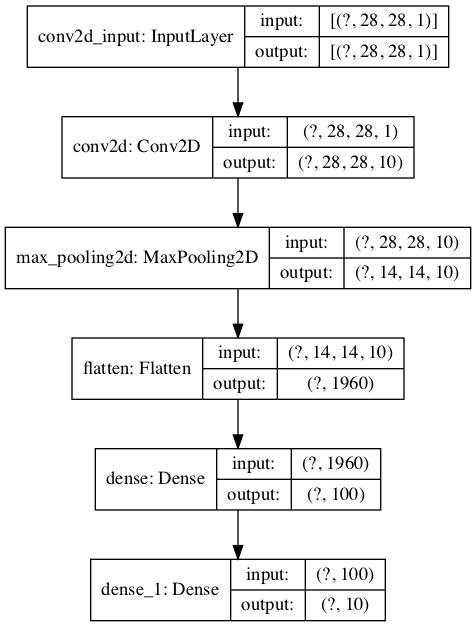

In [90]:
tf.keras.utils.plot_model(conv1, show_shapes=True)

In [91]:
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [92]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
history= conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 7s 151us/sample - loss: 0.4517 - accuracy: 0.8394 - val_loss: 0.3586 - val_accuracy: 0.8721
Epoch 2/20
48000/48000 [==============================] - 7s 140us/sample - loss: 0.3106 - accuracy: 0.8882 - val_loss: 0.2762 - val_accuracy: 0.9002
Epoch 3/20
48000/48000 [==============================] - 7s 144us/sample - loss: 0.2641 - accuracy: 0.9030 - val_loss: 0.2734 - val_accuracy: 0.8990
Epoch 4/20
48000/48000 [==============================] - 7s 142us/sample - loss: 0.2312 - accuracy: 0.9139 - val_loss: 0.2591 - val_accuracy: 0.9081
Epoch 5/20
48000/48000 [==============================] - 7s 141us/sample - loss: 0.2059 - accuracy: 0.9242 - val_loss: 0.2614 - val_accuracy: 0.9082
Epoch 6/20
48000/48000 [==============================] - 7s 141us/sample - loss: 0.1851 - accuracy: 0.9326 - val_loss: 0.2535 - val_accuracy: 0.9102
Epoch 7/20
48000/48000 [==========================

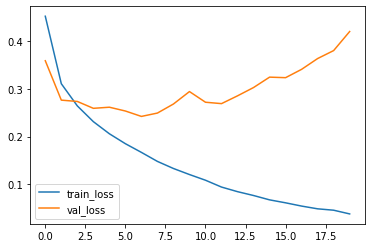

In [94]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()

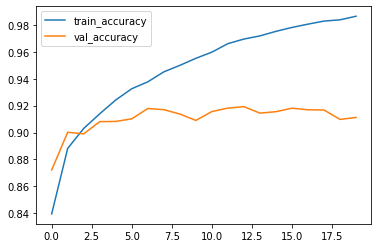

In [95]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [99]:
# dropout
from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3,3), activation='relu', padding='same', input_shape=(28,28, 1)))
conv2.add(MaxPooling2D((2,2)))
conv2.add(Flatten())
conv2.add(Dropout(.5))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

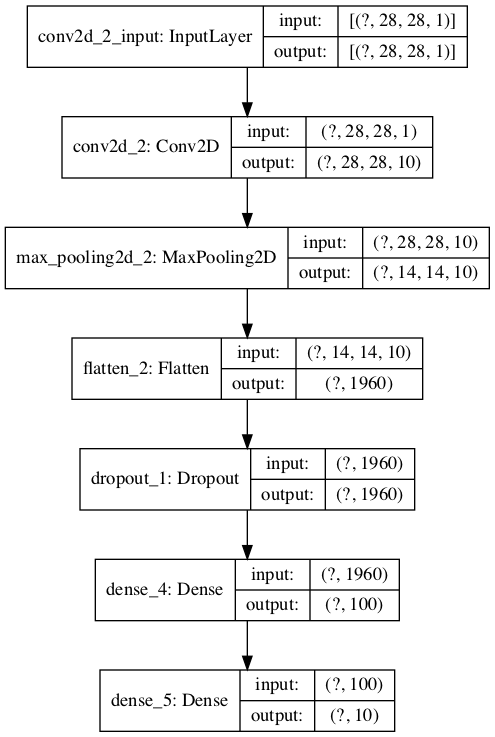

In [100]:
tf.keras.utils.plot_model(conv2, show_shapes=True)

In [101]:
conv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1960)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [102]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = conv2.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 7s 152us/sample - loss: 0.4876 - accuracy: 0.8271 - val_loss: 0.3479 - val_accuracy: 0.8788
Epoch 2/20
48000/48000 [==============================] - 7s 145us/sample - loss: 0.3593 - accuracy: 0.8714 - val_loss: 0.2999 - val_accuracy: 0.8940
Epoch 3/20
48000/48000 [==============================] - 7s 146us/sample - loss: 0.3211 - accuracy: 0.8810 - val_loss: 0.2664 - val_accuracy: 0.9029
Epoch 4/20
48000/48000 [==============================] - 7s 146us/sample - loss: 0.2946 - accuracy: 0.8922 - val_loss: 0.2638 - val_accuracy: 0.9057
Epoch 5/20
48000/48000 [==============================] - 7s 148us/sample - loss: 0.2779 - accuracy: 0.8976 - val_loss: 0.2489 - val_accuracy: 0.9112
Epoch 6/20
48000/48000 [==============================] - 7s 153us/sample - loss: 0.2614 - accuracy: 0.9016 - val_loss: 0.2426 - val_accuracy: 0.9128
Epoch 7/20
48000/48000 [==========================

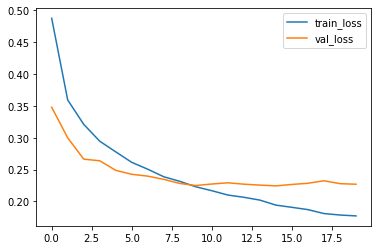

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.show()

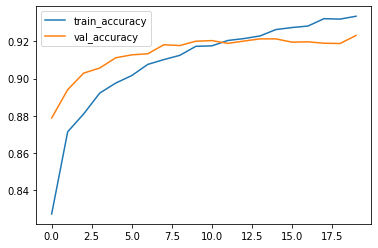

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [105]:
# pooling purpose : https://technical-support.tistory.com/65
